In [1]:
# Names: Max Collins, Marwan Bit, Nikolas Hall
# Physics 24A
# Prof. Saeta
# Final Project: Gravity Assist "Slingshot" Maneuver

In [13]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from p24asolver import P24ASolver
import math
import random

# Constants we'll need:


#SATM = 1.0   # Mass of the satellite
SATM = 4.15e-28
    

fpsq = 4 * (np.pi)**2 # Four pi-squared
G =  fpsq # Gravitational constant wrong units

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Traceback (most recent call last):
  File "C:\Users\Marwa\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\Marwa\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [14]:
def sun_fall(t ,Y, *args):
    return Y[0]**2+Y[2]**2
sun_fall.terminal = True

In [15]:
class Planet():
    """Allows us to create objects that represent the Sun and the planets."""
    
    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        #super().__init__(
         #   (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
         #    ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$'))
        #
        # Now store variables, using defaults, if necessary
        self.mass = kwargs.get('m', 1.0)        # Mass, in solar masses
        self.radius = kwargs.get('r', 0.00047)  # Planetary radius, in AU (default is for Jupiter)
        self.rorbit = kwargs.get('ro', 1.0)     # Orbital radius, in AU (assumes perfectly circular orbits)
        self.period = self.period = np.sqrt(((self.rorbit)**3) / (self.mass + 1))    # Period of orbit determined by other parameters
                                                                # In denominator, G multiplied by 1 solar mass => G
        self.ω = 0
        if self.period != 0:
            self.ω = (2* np.pi)/self.period
        
    def __str__(self):
        "Produces a string representation of the planet's parameters."
        string = "Mass: " + str(self.mass) + "  Radius: " + str(self.radius) + "  Radius of Orbit: " + str(self.rorbit) + "  Period: " + str(self.period)
        return str(string)
        # Add units, and figure out how to get each attribute onto a new line.
    
    def orbit(self, R, ω, t, t_off):
        """
        Arguments: R is the radius of orbit of a planet, ω is its angular speed, and t is the time of interest.
        Returns: Cartesian coordinates for position of the planet at time t.
        """
        return (R * np.math.cos(ω * (t+t_off)), R * np.math.sin(ω * (t+t_off)))
    

 # Planets for a default simulation
SUN = Planet(m = 1.0, r = 1, ro = 0.0)        # Figure out solar radius (AU) and Jupiter's mass (solar masses)
JUP = Planet(m = .00095, r = .5, ro = 5.2)

class Satellite(P24ASolver):
    """Allows us to define an object representing our space probe. Simulates a solar system of planets with perfectly circular orbits."""
    
    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        super().__init__(
            (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
             ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$')),
            rtol=1e-10, atol=1e-10
        )
        # Now store variables, using defaults, if necessary
        self.position = kwargs.get('r', [-1, 0])    # Satellite's position in Cartesian coordinates
                                                    # Default is x = -1 AU y = 0 AU
            
        self.velocity = kwargs.get('v', [0, 0])     # Satellite's velocity in the x- and y-directions
                                                    # Default is satellite at rest
            
        self.planets = kwargs.get('p', [SUN, JUP])  # A list of the planets that the satellite can interact with
                                                    # By default, includes the Sun and Jupiter
        self.events.append(sun_fall)
        
        self.time_offset = kwargs.get('t_off', 0)   #the time offset we need to launch at
        
        
        # We treat the satellite as though it has negligible mass and no radius
        # The satellite is a point moving through space
        
        
    def __str__(self):
        "Produces a string representation of a satellite."
        string = "Position: (x, y) = " + str(self.position) + "  Velocity: (vx, vy) = " + str(self.velocity)
        return str(string)
    

    
    def derivatives(self, t, Y):
        """ Accepts: Time of interest, derivatives vector, and """
        x1, v1, x2, v2 = Y  # Unpack the values
                            # x1 = x-position, v1 = x-velocity
                            # x2 = y-position, v2 = y-velocity
        
        
        
        numPlanets = len(self.planets)
        
        Alist = []
        
        for planet in self.planets:          # For each planet in the simulation...
            xp1, xp2 = planet.orbit(planet.rorbit, planet.ω, t, self.time_offset)    # Get the planet's cartesian position
            
            r_sq = (x1 - xp1)**2 + (x2 - xp2)**2   # Square of the satellite's distance from the current planet
            
            x = xp1 - x1
            y = xp2 - x2
            
            cosine_theta = y/np.sqrt(r_sq)
            
            sine_theta = x/np.sqrt(r_sq)
            
            # Get the components of the satellite's gravitational acceleration due to this planet
            a1 = float((G * planet.mass) / r_sq)*sine_theta
            a2 = float((G * planet.mass) / r_sq)*cosine_theta
            
#             if planet.mass == 1.0:
#                 print('accel due to sun:', '(',a1,a2,')')
            # Add those components to a list of accelerations
            Alist += [[a1, a2]]
            
        A1 = 0   # Total acceleration in the x-direction
        A2 = 0   # Total acceleration in the y-direction
        
        # Sum components to get the total x- and y-accelerations
        for a in Alist:
            A1 += a[0]
            A2 += a[1]
        
        return [v1, A1, v2, A2]   # Return a time derivative of Y
    
    

    

    def prepare_figure(self):
        """
        Function that creates the figure and axes for the animation.
        """

        fig, ax = plt.subplots(figsize = (10, 10))
        # We need to set the axes limits so each frame uses the same limits
        # I'll say that the center position of the first mass is at 2 and the second at 4
        ax.set_xlim((-10, 10))
        ax.set_ylim((-10, 10))

        self.shapes = [Circle(self.position, radius = .05, color = 'r')]
        
        for planet in self.planets:
            self.shapes.append(Circle(planet.orbit(planet.rorbit, planet.ω, 0, self.time_offset), radius = planet.radius, color = 'b'))

        
        for s in self.shapes:
            ax.add_patch(s)
        return fig, ax

    def draw_frame(self, t):
        """
        Draw frame for time t
        """

        x1, v1, x2, v2 = self.solution.sol(t)
        
        
        # First step is to remove the existing shapes
        for n in range(len(self.shapes)-1, -1, -1):
            self.shapes[n].remove()
                                
        self.shapes = [Circle((x1,x2), radius = .05, color = 'r')]
        
        for planet in self.planets:
            self.shapes.append(Circle(planet.orbit(planet.rorbit, planet.ω, t, self.time_offset), radius = planet.radius, color = 'b'))
            
        for s in self.shapes:
            self._ax.add_patch(s)

#         title = self._ax.set_title(f"t = {t:.2f}", usetex=False)

        # By returning the list of Artists that have changed,
        # we speed up the animation
        return self.shapes

In [27]:
def KE(t, solution):
    """
    returns the kinetic energy of the satellite at t gives a solution
    """
    return .5*SATM*(solution(t)[1]**2+solution(t)[3]**2)

def Tot_Energy(t, solution, JUP):
    '''
    This function takes in the time and returns an expression for the energy...
    '''
    
    K_sat = KE(t, solution)
    #now let's get the potential due to the sun
    sun_radius = np.sqrt(solution(t)[0]**2 + solution(t)[2]**2)
    U_sun = - 4*(((math.pi)**2)*SATM/sun_radius)
    sol1 = solution
    jup_radii = np.sqrt((JUP.orbit(JUP.rorbit,JUP.ω, t,0)[0] -sol1(t)[0])**2+(JUP.orbit(JUP.rorbit,JUP.ω, t,0)[1]-sol1(t)[2])**2)
    U_jup = (-4*(math.pi)**2 *(JUP.mass)*SATM)/(jup_radii)
    
    return K_sat + U_sun + U_jup
    
    

In [28]:
Sat = Satellite(t_off = 0)
rest = (0,9.77,-1,0)
sol1 = Sat.solve(rest, (0,4))
times = np.linspace(0,4,100)
# succesful launch at offset: 1.845313921747043 x_vel: 3.4 y_vel: 7.790378681424928

<IPython.core.display.Javascript object>


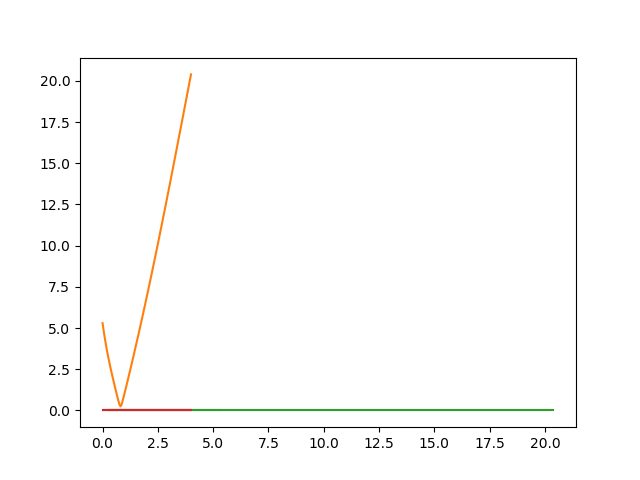

[3.419994154212209e-27, 3.420007058470026e-27, 3.420022450437851e-27, 3.420040257606556e-27, 3.420060380750102e-27, 3.420082757716078e-27, 3.420107392185014e-27, 3.420134363201678e-27, 3.420163883514133e-27, 3.4201963415964014e-27, 3.420232426534881e-27, 3.420273350678515e-27, 3.420321323076054e-27, 3.42038056243152e-27, 3.42045969015656e-27, 3.420577905191653e-27, 3.420783102581741e-27, 3.421214441969058e-27, 3.422371524262136e-27, 3.4265888870047205e-27, 3.44371531054663e-27, 3.467539204549858e-27, 3.4767430417023125e-27, 3.4800439321177156e-27, 3.48158852145553e-27, 3.482465802613784e-27, 3.4830314561880946e-27, 3.483428904656423e-27, 3.4837256663407095e-27, 3.483957359181055e-27, 3.4841444672700125e-27, 3.4842995889054974e-27, 3.484430897497315e-27, 3.4845439409819606e-27, 3.4846426211454974e-27, 3.48472975480823e-27, 3.484807447603086e-27, 3.48487730238239e-27, 3.484940549172728e-27, 3.4849981800922774e-27, 3.485050967187054e-27, 3.4850995565218144e-27, 3.48514446405637e-27, 3.485

In [29]:
KE_list = [KE(t, sol1) for t in times]
jup_radii = [np.sqrt((JUP.orbit(JUP.rorbit,JUP.ω, t,0)[0] -sol1(t)[0])**2+(JUP.orbit(JUP.rorbit,JUP.ω, t,0)[1]-sol1(t)[2])**2) for t in times]


fig, ax = plt.subplots()
ax.plot(times, KE_list); #blue line
ax.plot(times, jup_radii); #orange line
ax.plot(jup_radii, KE_list); #green line (indicate that KE actually decreases the closer we get to jup)

#now let's try to make a a total energy graph
Tot_energy_list = [Tot_Energy(t, sol1, JUP) for t in times]
ax.plot(times, Tot_energy_list)
print(Tot_energy_list)

<IPython.core.display.Javascript object>


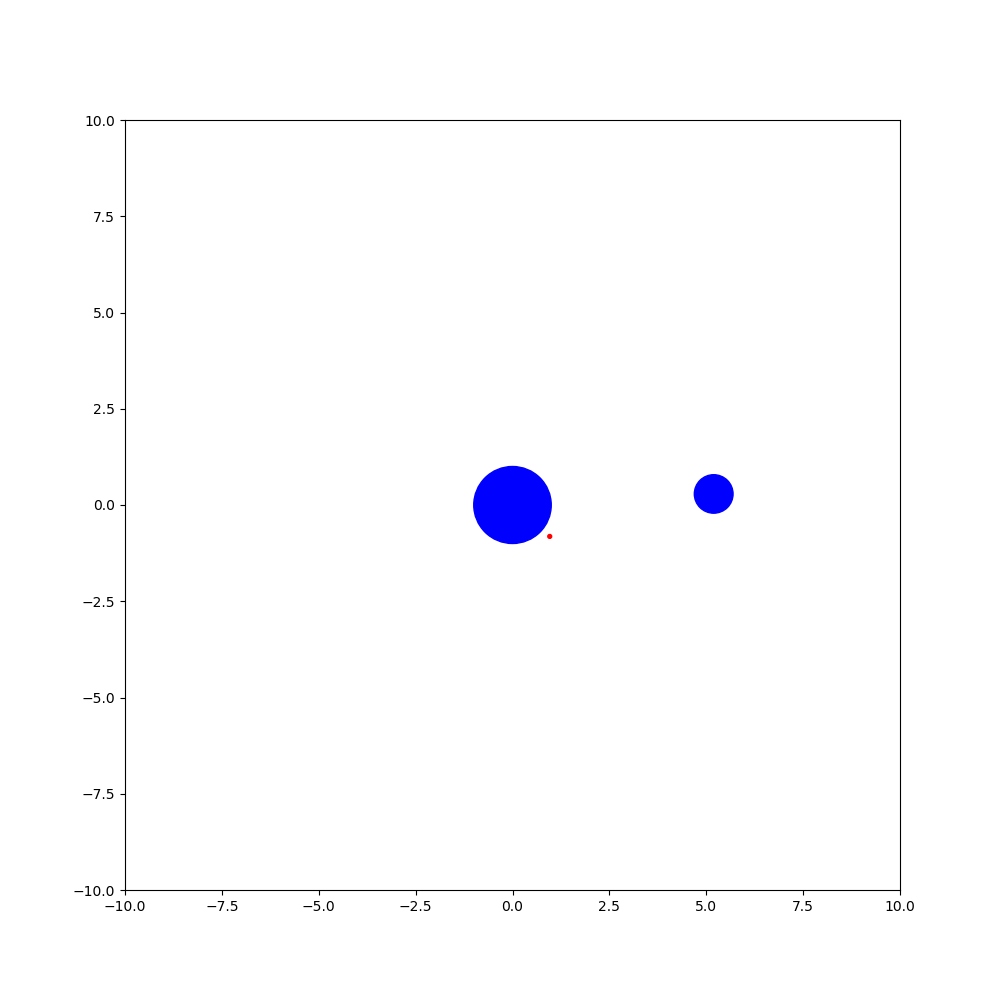

In [25]:
sol1.animate(500);

In [9]:
def path_finder(max_vel, max_vel_steps, approach_dist):
    """
    input: max_vel is the maximum total velocity, sol is a solved satellite
    """
    launches = []
    times = np.linspace(0,5,1825)
    count = 0
    give_up_count = 0
    ##### To start we'll pick a date to launch at. since jupiter has a 12 year orbit, we'll allow any day of that orbit for launch #####
    for offset in np.linspace(0,12,1100):
        count += 1
        print(count)
        if give_up_count == 1100*10:
            return launches
    ##### next we need to determine the speed we'll launch at #######
        for x_vel in np.linspace(0, max_vel, max_vel_steps):
            y_vel = np.sqrt(max_vel**2 - x_vel**2)
            
    ##### we launch from the earth ###################################
            init_pos = (1,x_vel,0,y_vel)
            sol = Satellite(t_off = offset).solve(init_pos,(0,5))
            
    ##### first we check that the satellite reaches a point where it's reasonably close to Jupiter ####
            jup_radii = [np.sqrt((JUP.orbit(JUP.rorbit,JUP.ω, t,offset)[0] -sol(t)[0])**2+(JUP.orbit(JUP.rorbit,JUP.ω, t,offset)[1]-sol(t)[2])**2) for t in times]
            if min(jup_radii) < approach_dist and min(jup_radii) > 0.0004673296:
                    give_up_count = 0
                    print('succesful approach at offset:', offset, 'x_vel:', x_vel, 'y_vel:',y_vel)
                    
                    ##### now we look for an increase in velocity #############
                    velocities = [np.sqrt(sol(t)[1]**2+sol(t)[3]**2) for t in times]
                    if max(velocities) > max_vel:
                        print('succesful launch at offset:', offset, 'x_vel:', x_vel, 'y_vel:',y_vel)
                        launches.append((offset, x_vel,y_vel))
    #### if jup
            else:
                give_up_count += 1
    return launches

path_finder(8, 16, 1)

1
succesful approach at offset: 0.0 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.0 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.0 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.0 x_vel: 6.4 y_vel: 4.799999999999999
succesful approach at offset: 0.0 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
succesful launch at offset: 0.0 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
succesful approach at offset: 0.0 x_vel: 7.466666666666667 y_vel: 2.8720878971384014
succesful launch at offset: 0.0 x_vel: 7.466666666666667 y_vel: 2.8720878971384014
2
succesful approach at offset: 0.01091901728844404 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.01091901728844404 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.01091901728844404 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.01091901728844404 x_vel: 6.4 y_vel: 4.

succesful launch at offset: 0.10919017288444041 x_vel: 7.466666666666667 y_vel: 2.8720878971384014
12
succesful approach at offset: 0.12010919017288445 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset: 0.12010919017288445 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful approach at offset: 0.12010919017288445 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.12010919017288445 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.12010919017288445 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.12010919017288445 x_vel: 6.4 y_vel: 4.799999999999999
succesful approach at offset: 0.12010919017288445 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
succesful launch at offset: 0.12010919017288445 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
13
succesful approach at offset: 0.13102820746132848 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset:

succesful approach at offset: 0.22929936305732485 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.22929936305732485 x_vel: 6.4 y_vel: 4.799999999999999
succesful approach at offset: 0.22929936305732485 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
succesful launch at offset: 0.22929936305732485 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
23
succesful approach at offset: 0.2402183803457689 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset: 0.2402183803457689 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful approach at offset: 0.2402183803457689 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.2402183803457689 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.2402183803457689 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.2402183803457689 x_vel: 6.4 y_vel: 4.799999999999999
succesful approach at offset: 0.2402183803457689 x_vel: 6.9333333

succesful approach at offset: 0.3494085532302093 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.3494085532302093 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.3494085532302093 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.3494085532302093 x_vel: 6.4 y_vel: 4.799999999999999
succesful approach at offset: 0.3494085532302093 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
succesful launch at offset: 0.3494085532302093 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
34
succesful approach at offset: 0.36032757051865333 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset: 0.36032757051865333 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful approach at offset: 0.36032757051865333 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.36032757051865333 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.360

44
succesful approach at offset: 0.46951774340309377 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset: 0.46951774340309377 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful approach at offset: 0.46951774340309377 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.46951774340309377 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.46951774340309377 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.46951774340309377 x_vel: 6.4 y_vel: 4.799999999999999
succesful approach at offset: 0.46951774340309377 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
succesful launch at offset: 0.46951774340309377 x_vel: 6.933333333333334 y_vel: 3.9911012125588705
45
succesful approach at offset: 0.4804367606915378 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset: 0.4804367606915378 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful approach at offset: 

succesful approach at offset: 0.6005459508644222 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset: 0.6005459508644222 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful approach at offset: 0.6005459508644222 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.6005459508644222 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.6005459508644222 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.6005459508644222 x_vel: 6.4 y_vel: 4.799999999999999
57
succesful approach at offset: 0.6114649681528663 x_vel: 4.8 y_vel: 6.4
succesful launch at offset: 0.6114649681528663 x_vel: 4.8 y_vel: 6.4
succesful approach at offset: 0.6114649681528663 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset: 0.6114649681528663 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful approach at offset: 0.6114649681528663 x_vel: 5.866666666666666 y_vel: 5.4389541478323045

succesful launch at offset: 0.7206551410373067 x_vel: 6.4 y_vel: 4.799999999999999
68
succesful approach at offset: 0.7315741583257508 x_vel: 4.8 y_vel: 6.4
succesful launch at offset: 0.7315741583257508 x_vel: 4.8 y_vel: 6.4
succesful approach at offset: 0.7315741583257508 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful launch at offset: 0.7315741583257508 x_vel: 5.333333333333333 y_vel: 5.962847939999439
succesful approach at offset: 0.7315741583257508 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful launch at offset: 0.7315741583257508 x_vel: 5.866666666666666 y_vel: 5.4389541478323045
succesful approach at offset: 0.7315741583257508 x_vel: 6.4 y_vel: 4.799999999999999
succesful launch at offset: 0.7315741583257508 x_vel: 6.4 y_vel: 4.799999999999999
69
succesful approach at offset: 0.7424931756141948 x_vel: 4.8 y_vel: 6.4
succesful launch at offset: 0.7424931756141948 x_vel: 4.8 y_vel: 6.4
succesful approach at offset: 0.7424931756141948 x_vel: 5.33333333333

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


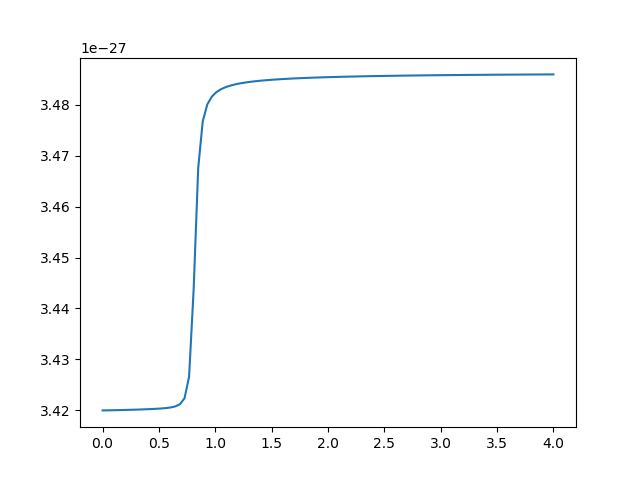

[3.419994154212209e-27, 3.420007058470026e-27, 3.420022450437851e-27, 3.420040257606556e-27, 3.420060380750102e-27, 3.420082757716078e-27, 3.420107392185014e-27, 3.420134363201678e-27, 3.420163883514133e-27, 3.4201963415964014e-27, 3.420232426534881e-27, 3.420273350678515e-27, 3.420321323076054e-27, 3.42038056243152e-27, 3.42045969015656e-27, 3.420577905191653e-27, 3.420783102581741e-27, 3.421214441969058e-27, 3.422371524262136e-27, 3.4265888870047205e-27, 3.44371531054663e-27, 3.467539204549858e-27, 3.4767430417023125e-27, 3.4800439321177156e-27, 3.48158852145553e-27, 3.482465802613784e-27, 3.4830314561880946e-27, 3.483428904656423e-27, 3.4837256663407095e-27, 3.483957359181055e-27, 3.4841444672700125e-27, 3.4842995889054974e-27, 3.484430897497315e-27, 3.4845439409819606e-27, 3.4846426211454974e-27, 3.48472975480823e-27, 3.484807447603086e-27, 3.48487730238239e-27, 3.484940549172728e-27, 3.4849981800922774e-27, 3.485050967187054e-27, 3.4850995565218144e-27, 3.48514446405637e-27, 3.485

In [30]:
#Now that we have the ability to graph our KE vs. Radial distance from Jupiter graph we need to determine what shape specifies a "boost"
#It seems Kinetic Energy decreases but it may change the trajectory????

'''
Ideas on What to do next:  

-Graph's/verification of angular displacement before and after a slingshot event 

-Using Max's code to find what an "optimal path" is

-E/m = 1/2 v^2 - GM/r -GM_p/s  (Try making a plot for this and then)

#Tixy and Latex!!!

-Longest Sublists for iterative approaches for pathfinding

-Energy Curve for a successful should have increasing sublists

-Way to recognize jumps in the Energy Plot (so we can search for paths :) )


'''

#now let's try to make a a total energy graph
fig1, ax1 = plt.subplots()
Tot_energy_list = [Tot_Energy(t, sol1, JUP) for t in times]
ax1.plot(times, Tot_energy_list)
print(Tot_energy_list)

In [46]:
#Now let's try simulating plots for different launch parameters 
#Let's create a bunch of different sats..
vel = [random.random()*10,random.random()*10]
print(vel)
Sat = Satellite(v= vel, t_off= -3)
#now let's create random conditions
rest = (0,0,0,0)
#now let's solve....
solution = Sat.solve(rest, (0,12))
times = np.linspace(0,12,100)
#Now let's plot the graphs....
Tot_energy_list = [Tot_Energy(t, sol1, JUP) for t in times]
print(Tot_energy_list)
    

#Kinetic energy may not be kinetic energy of the whole system......
#Shoot prof Saeta an email about trouble shooting TE graphs and why SATM affects them so drastically, truncation error due to mass?
#Error in Units/Estimation?, could be graphing it wrong?

[1.8025658831121505, 9.639297495599497]


C:\Users\Marwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Marwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Marwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Marwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in double_scalars


[-30.48734724643461, -30.488080183931473, -30.48770429424529, -30.48598481473561, -30.486654274215297, -30.487879290328724, -30.48807852314325, -30.487102234528987, -30.4859321872514, -30.487198237271112, -30.487925497698207, -30.48771616505613, -30.485708289868185, -30.486333601366656, -30.487241336973543, -30.487737022598093, -30.486733113977884, -30.485700771296347, -30.48629075374374, -30.48714586029025, -30.487591667974662, -30.485604027732624, -30.485462542883447, -30.48618445484071, -30.487301548134155, -30.486071997821277, -30.485066006695494, -30.485248798990693, -30.48639185708539, -30.487048291322722, -30.485148306750737, -30.484682046793342, -30.485352065279915, -30.48718900390885, -30.485518438542154, -30.484574025831257, -30.484615279687212, -30.48598773757479, -30.48598204054535, -30.48476362586097, -30.484340786359414, -30.484942517603198, -30.48650285003511, -30.485053784087814, -30.4844072311632, -30.48440412934346, -30.486125369687326, -30.485346821670547, -30.484625